In [1]:

import os 
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import numpy as np 
import cv2 
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
from torchvision import transforms 
from IPython.display import clear_output

from src import DataInit,MVtecADDataset


In [2]:
def load_gt(root, cls):
    gt = []
    gt_dir = os.path.join(root, cls, 'ground_truth')
    sub_dirs = sorted(os.listdir(gt_dir))
    for sb in sub_dirs:
        for fname in sorted(os.listdir(os.path.join(gt_dir, sb))):
            temp = cv2.imread(os.path.join(gt_dir, sb, fname), cv2.IMREAD_GRAYSCALE)
            temp = cv2.resize(temp, (256, 256)).astype(np.bool)[None, ...]
            gt.append(temp)
    gt = np.concatenate(gt, 0)
    return  gt

def preprocess(cfg,augmentation=None):
    #mk save dir 
    try:
        os.mkdir(f"./Save_models/{cfg['class']}")
    except:
        pass
    #Seed fix 
    torch.manual_seed(cfg['seed'])
    np.random.seed(cfg['seed'])

    #Data load 
    Data_dir = DataInit(cfg['root'],cfg['class'])
    train_dirs = Data_dir.train_load()
    test_dirs,test_labels = Data_dir.test_load()
    
    #Ground truth 
    gt = load_gt(cfg['root'],cfg['class'])
    true_gt = np.zeros((len(test_labels), 256, 256), dtype=np.bool)
    true_gt[np.where(test_labels==1)[0]]= gt

    #DataLoader
    indx = int(len(train_dirs)*0.8)
    train_dset = MVtecADDataset(cfg,train_dirs[:indx],Augmentation=augmentation)
    valid_dset = MVtecADDataset(cfg,train_dirs[indx:])
    test_dset = MVtecADDataset(cfg,test_dirs,test_labels)

    train_loader = DataLoader(train_dset,batch_size=cfg['batch_size'],shuffle=True)
    valid_loader = DataLoader(valid_dset,batch_size=cfg['batch_size'],shuffle=False)
    test_loader = DataLoader(test_dset,batch_size=cfg['batch_size'],shuffle=False)
    return train_loader,valid_loader,test_loader,true_gt,test_labels 

   
def make_transform():
    transform = transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform

def make_lossfunction(loss_function):
    if loss_function == 'mse':
        return nn.MSELoss

In [4]:
cfg = {} 
cfg['img_size']= 256 
cfg['batch_size']= 32 
cfg['lr'] = 0.4
cfg['Epochs'] = 100 
cfg['device'] = 'cuda:0'
cfg['seed'] = 0 
cfg['root'] = './Dataset'
cfg['class'] = 'toothbrush'
cfg['lambda'] = 0.01
cfg['loss_function'] = 'mse'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


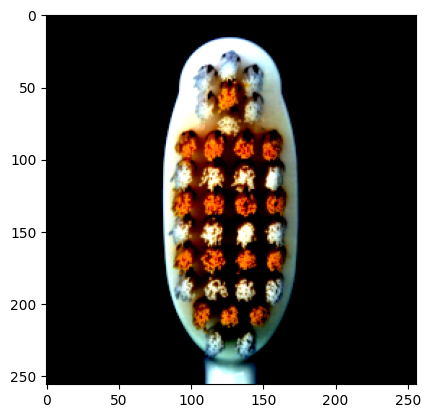

In [14]:
device = cfg['device']
transform = make_transform()
train_loader,valid_loader,test_loader,true_gt,test_labels = preprocess(cfg,transform)


a,b = next(iter(train_loader))
plt.imshow(a[0].permute(1,2,0).detach().cpu().numpy())


